In [1]:
import pandas as pd
import datetime
import collections
import numpy as np
import os
from matplotlib import pyplot as plt
from itertools import combinations
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import statsmodels.api as sm
%matplotlib inline
os.chdir(r"C:\Users\senwangw\Desktop\pydata")

In [2]:
loan_data=pd.read_csv('loan_data_2007_2014.csv') 
loan_data.head()

C:\Users\senwangw\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
pd.options.display.max_columns=None

In [4]:
loan_data.columns.values

array(['Unnamed: 0', 'id', 'member_id', 'loan_amnt', 'funded_amnt',
       'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade',
       'sub_grade', 'emp_title', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'issue_d', 'loan_status',
       'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'collection_recovery_fee', 'last_pymnt_d',
       'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint',
       'veri

In [5]:
loan_data['emp_length'].unique()

array(['10+ years', '< 1 year', '1 year', '3 years', '8 years', '9 years',
       '4 years', '5 years', '6 years', '2 years', '7 years', nan],
      dtype=object)

In [6]:
#clean data for year column
loan_data['emp_length_int'] = loan_data['emp_length'].str.replace('\+ years', '')
loan_data['emp_length_int'] = loan_data['emp_length_int'].str.replace('< 1 year', str(0))
loan_data['emp_length_int'] = loan_data['emp_length_int'].str.replace('n/a',  str(0))
loan_data['emp_length_int'] = loan_data['emp_length_int'].str.replace(' years', '')
loan_data['emp_length_int'] = loan_data['emp_length_int'].str.replace(' year', '')

In [7]:
loan_data['emp_length_int']=pd.to_numeric(loan_data['emp_length_int'])

In [8]:
type(loan_data['emp_length_int'][0])

numpy.float64

In [9]:
loan_data['earliest_cr_line_date'] = pd.to_datetime(loan_data['earliest_cr_line'],format = '%b-%y')

In [10]:
loan_data['mths_since_earliest_cr_line']=round(pd.to_numeric((pd.to_datetime('2017-12-01')-loan_data['earliest_cr_line_date'])/np.timedelta64(1, 'M')))

In [11]:
loan_data['mths_since_earliest_cr_line'].describe()

count    466256.000000
mean        239.482430
std          93.974829
min        -612.000000
25%         183.000000
50%         225.000000
75%         285.000000
max         587.000000
Name: mths_since_earliest_cr_line, dtype: float64

In [12]:
loan_data.loc[: , ['earliest_cr_line', 'earliest_cr_line_date', 'mths_since_earliest_cr_line']][loan_data['mths_since_earliest_cr_line']<0]

,earliest_cr_line,earliest_cr_line_date,mths_since_earliest_cr_line
1580,Sep-62,2062-09-01,-537.0
1770,Sep-68,2068-09-01,-609.0
2799,Sep-64,2064-09-01,-561.0
3282,Sep-67,2067-09-01,-597.0
3359,Feb-65,2065-02-01,-566.0
3413,Jun-67,2067-06-01,-594.0
3607,Aug-67,2067-08-01,-596.0
3989,Dec-63,2063-12-01,-552.0
4440,Sep-68,2068-09-01,-609.0
4449,Sep-68,2068-09-01,-609.0


In [13]:
loan_data['mths_since_earliest_cr_line'][loan_data['mths_since_earliest_cr_line']<0]=loan_data['mths_since_earliest_cr_line'].max()

C:\Users\senwangw\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [14]:
min(loan_data['mths_since_earliest_cr_line'])

73.0

In [15]:
loan_data['term'].describe()
loan_data['term'].unique()

array([' 36 months', ' 60 months'], dtype=object)

In [16]:
loan_data['term_int']=loan_data['term'].str.replace(' months', '')
loan_data['term_int']

0          36
1          60
2          36
3          36
4          60
5          36
6          60
7          36
8          60
9          60
10         60
11         36
12         36
13         36
14         36
15         36
16         36
17         36
18         36
19         36
20         60
21         36
22         36
23         36
24         36
25         36
26         36
27         60
28         36
29         36
         ... 
466255     36
466256     36
466257     36
466258     36
466259     36
466260     36
466261     36
466262     36
466263     36
466264     36
466265     36
466266     36
466267     36
466268     36
466269     60
466270     36
466271     36
466272     60
466273     36
466274     36
466275     36
466276     60
466277     36
466278     36
466279     36
466280     60
466281     60
466282     60
466283     36
466284     36
Name: term_int, Length: 466285, dtype: object

In [17]:
loan_data['term_int']=pd.to_numeric(loan_data['term_int'])
type(loan_data['term_int'][0])

numpy.int64

In [18]:
loan_data['issue_d_date'] = pd.to_datetime(loan_data['issue_d'], format = '%b-%y')
loan_data['mths_since_issue_d'] = round(pd.to_numeric((pd.to_datetime('2017-12-01') - loan_data['issue_d_date']) / np.timedelta64(1, 'M')))
loan_data['mths_since_issue_d'].describe()

count    466285.000000
mean         51.255187
std          14.340154
min          36.000000
25%          41.000000
50%          47.000000
75%          57.000000
max         126.000000
Name: mths_since_issue_d, dtype: float64

In [19]:
pd.get_dummies(loan_data['grade'])

,A,B,C,D,E,F,G
0,0,1,0,0,0,0,0
1,0,0,1,0,0,0,0
2,0,0,1,0,0,0,0
3,0,0,1,0,0,0,0
4,0,1,0,0,0,0,0
5,1,0,0,0,0,0,0
6,0,0,1,0,0,0,0
7,0,0,0,0,1,0,0
8,0,0,0,0,0,1,0
9,0,1,0,0,0,0,0


In [20]:
pd.get_dummies(loan_data['grade'], prefix = 'grade', prefix_sep = ':')

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G
0,0,1,0,0,0,0,0
1,0,0,1,0,0,0,0
2,0,0,1,0,0,0,0
3,0,0,1,0,0,0,0
4,0,1,0,0,0,0,0
5,1,0,0,0,0,0,0
6,0,0,1,0,0,0,0
7,0,0,0,0,1,0,0
8,0,0,0,0,0,1,0
9,0,1,0,0,0,0,0


In [21]:
loan_data_dummies = [pd.get_dummies(loan_data['grade'], prefix = 'grade', prefix_sep = ':'),
                     pd.get_dummies(loan_data['sub_grade'], prefix = 'sub_grade', prefix_sep = ':'),
                     pd.get_dummies(loan_data['home_ownership'], prefix = 'home_ownership', prefix_sep = ':'),
                     pd.get_dummies(loan_data['verification_status'], prefix = 'verification_status', prefix_sep = ':'),
                     pd.get_dummies(loan_data['loan_status'], prefix = 'loan_status', prefix_sep = ':'),
                     pd.get_dummies(loan_data['purpose'], prefix = 'purpose', prefix_sep = ':'),
                     pd.get_dummies(loan_data['addr_state'], prefix = 'addr_state', prefix_sep = ':'),
                     pd.get_dummies(loan_data['initial_list_status'], prefix = 'initial_list_status', prefix_sep = ':')]

In [22]:
loan_data_dummies=pd.concat(loan_data_dummies, axis = 1)

In [23]:
loan_data=pd.concat([loan_data,loan_data_dummies], axis=1)

In [24]:
loan_data.columns.values

array(['Unnamed: 0', 'id', 'member_id', 'loan_amnt', 'funded_amnt',
       'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade',
       'sub_grade', 'emp_title', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'issue_d', 'loan_status',
       'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'collection_recovery_fee', 'last_pymnt_d',
       'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint',
       'veri

In [25]:
loan_data.isnull()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,emp_length_int,earliest_cr_line_date,mths_since_earliest_cr_line,term_int,issue_d_date,mths_since_issue_d,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,sub_grade:A1,sub_grade:A2,sub_grade:A3,sub_grade:A4,sub_grade:A5,sub_grade:B1,sub_grade:B2,sub_grade:B3,sub_grade:B4,sub_grade:B5,sub_grade:C1,sub_grade:C2,sub_grade:C3,sub_grade:C4,sub_grade:C5,sub_grade:D1,sub_grade:D2,sub_grade:D3,sub_grade:D4,sub_grade:D5,sub_grade:E1,sub_grade:E2,sub_grade:E3,sub_grade:E4,sub_grade:E5,sub_grade:F1,sub_grade:F2,sub_grade:F3,sub_grade:F4,sub_grade:F5,sub_grade:G1,sub_grade:G2,sub_grade:G3,sub_grade:G4,sub_grade:G5,home_ownership:ANY,home_ownership:MORTGAGE,home_ownership:NONE,home_ownership:OTHER,home_ownership:OWN,home_ownership:RENT,verification_status:Not Verified,verification_status:Source Verified,verification_status:Verified,loan_status:Charged Off,loan_status:Current,loan_status:Default,loan_status:Does not meet the credit policy. Status:Charged Off,loan_status:Does not meet the credit policy. Status:Fully Paid,loan_status:Fully Paid,loan_status:In Grace Period,loan_status:Late (16-30 days),loan_status:Late (31-120 days),purpose:car,purpose:credit_card,purpose:debt_consolidation,purpose:educational,purpose:home_improvement,purpose:house,purpose:major_purchase,purpose:medical,purpose:moving,purpose:other,purpose:renewable_energy,purpose:small_business,purpose:vacation,purpose:wedding,addr_state:AK,addr_state:AL,addr_state:AR,addr_state:AZ,addr_state:CA,addr_state:CO,addr_state:CT,addr_state:DC,addr_state:DE,addr_state:FL,addr_state:GA,addr_state:HI,addr_state:IA,addr_state:ID,addr_state:IL,addr_state:IN,addr_state:KS,addr_state:KY,addr_state:LA,addr_state:MA,addr_state:MD,addr_state:ME,addr_state:MI,addr_state:MN,addr_state:MO,addr_state:MS,addr_state:MT,addr_state:NC,addr_state:NE,addr_state:NH,addr_state:NJ,addr_state:NM,addr_state:NV,addr_state:NY,addr_state:OH,addr_state:OK,addr_state:OR,addr_state:PA,addr_state:RI,addr_state:SC,addr_state:SD,addr_state:TN,addr_state:TX,addr_state:UT,addr_state:VA,addr_state:VT,addr_state:WA,addr_state:WI,addr_state:WV,addr_state:WY,initial_list_status:f,initial_list_status:w
0,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fal

In [26]:
pd.options.display.max_rows= 100
loan_data['total_rev_hi_lim'].fillna(loan_data['funded_amnt'],inplace=True)


In [27]:
loan_data['total_rev_hi_lim'].isnull().sum()

0

In [28]:
loan_data['annual_inc'].fillna(loan_data['annual_inc'].mean(), inplace=True)

In [29]:
loan_data['mths_since_earliest_cr_line'].fillna(0, inplace=True)
loan_data['acc_now_delinq'].fillna(0, inplace=True)
loan_data['total_acc'].fillna(0, inplace=True)
loan_data['pub_rec'].fillna(0, inplace=True)
loan_data['open_acc'].fillna(0, inplace=True)
loan_data['inq_last_6mths'].fillna(0, inplace=True)
loan_data['delinq_2yrs'].fillna(0, inplace=True)
loan_data['emp_length_int'].fillna(0, inplace=True)

In [30]:
loan_data['loan_status'].value_counts()

Current                                                224226
Fully Paid                                             184739
Charged Off                                             42475
Late (31-120 days)                                       6900
In Grace Period                                          3146
Does not meet the credit policy. Status:Fully Paid       1988
Late (16-30 days)                                        1218
Default                                                   832
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

In [31]:
loan_data['good_bad']=np.where(loan_data['loan_status'].isin(['Charged off','Default',
                                                              'Does not meet the credit policy. Status:Charged Off',
                                                             'Late (31-120 days)']), 0, 1)

In [32]:
loan_data['good_bad']

0         1
1         1
2         1
3         1
4         1
5         1
6         1
7         1
8         1
9         1
10        1
11        1
12        1
13        1
14        1
15        1
16        1
17        1
18        1
19        1
20        1
21        1
22        1
23        1
24        1
25        1
26        1
27        1
28        1
29        1
30        1
31        1
32        1
33        1
34        1
35        1
36        1
37        1
38        1
39        1
40        1
41        1
42        1
43        1
44        1
45        1
46        1
47        1
48        1
49        1
         ..
466235    1
466236    1
466237    1
466238    1
466239    1
466240    1
466241    1
466242    1
466243    1
466244    1
466245    1
466246    1
466247    1
466248    1
466249    1
466250    1
466251    0
466252    1
466253    1
466254    1
466255    1
466256    1
466257    1
466258    1
466259    1
466260    1
466261    1
466262    1
466263    1
466264    1
466265    1
466266    1
4662

In [33]:
from sklearn.model_selection import train_test_split

In [34]:
train_test_split(loan_data.drop('good_bad',axis = 1),loan_data['good_bad'])

[        Unnamed: 0        id  member_id  loan_amnt  funded_amnt  \
 397506      397506  15431034   17503368      11075        11075   
 370928      370928  18905142   21087851       2000         2000   
 239324      239324  34081866   36765132      12000        12000   
 136834      136834   5044751    6366902      10000        10000   
 89235        89235   7384594    9046744      24925        24925   
 101900      101900   6699295    8301566       8000         8000   
 108647      108647   6547944    8100057      16800        16800   
 59979        59979   8979079   10781008      10000        10000   
 237601      237601  36450859   39172537      20000        20000   
 82026        82026   7668681    9350632      18000        18000   
 65427        65427   8669383   10441170      20000        20000   
 415950      415950  12304919   14297070      28000        28000   
 222347      222347   1205090    1446451       7000         7000   
 282080      282080  30626237   33179447      12

In [35]:
loan_data_inputs_train, loan_data_inputs_test, loan_data_targets_train, loan_data_targets_test = train_test_split(loan_data.drop('good_bad', axis = 1), loan_data['good_bad'])

In [36]:
loan_data_inputs_train.shape

(349713, 207)

In [37]:
loan_data_inputs_train, loan_data_inputs_test, loan_data_targets_train, loan_data_targets_test = train_test_split(loan_data.drop('good_bad', axis = 1), loan_data['good_bad'], test_size = 0.2, random_state = 42)

In [38]:
df_inputs=loan_data_inputs_train
df_target=loan_data_targets_train

In [39]:
df_inputs['grade'].unique()

array(['A', 'C', 'D', 'B', 'E', 'F', 'G'], dtype=object)

In [40]:
df1=pd.concat([df_inputs['grade'],df_target],axis=1)

In [41]:
df1.head()

,grade,good_bad
427211,A,1
206088,C,1
136020,A,1
412305,D,0
36159,C,1


In [42]:
df1.groupby(df1.columns.values[0],as_index=False)[df1.columns.values[1]].count()

,grade,good_bad
0,A,59759
1,B,109730
2,C,100245
3,D,61498
4,E,28612
5,F,10530
6,G,2654


In [43]:
df1.groupby(df1.columns.values[0],as_index=False)[df1.columns.values[1]].mean()

,grade,good_bad
0,A,0.995064
1,B,0.988280
2,C,0.980199
3,D,0.973072
4,E,0.964945
5,F,0.962108
6,G,0.944235


In [44]:
df1=pd.concat([df1.groupby(df1.columns.values[0],as_index=False)[df1.columns.values[1]].count(),
               df1.groupby(df1.columns.values[0],as_index=False)[df1.columns.values[1]].mean()],axis=1)

In [45]:
df1

,grade,good_bad,grade,good_bad
0,A,59759,A,0.995064
1,B,109730,B,0.988280
2,C,100245,C,0.980199
3,D,61498,D,0.973072
4,E,28612,E,0.964945
5,F,10530,F,0.962108
6,G,2654,G,0.944235


In [46]:
df1=df1.iloc[: , [0, 1, 3]]
df1

,grade,good_bad,good_bad
0,A,59759,0.995064
1,B,109730,0.988280
2,C,100245,0.980199
3,D,61498,0.973072
4,E,28612,0.964945
5,F,10530,0.962108
6,G,2654,0.944235


In [47]:
df1.columns=[df1.columns.values[0],'n_obs', 'prop_good']
df1

,grade,n_obs,prop_good
0,A,59759,0.995064
1,B,109730,0.988280
2,C,100245,0.980199
3,D,61498,0.973072
4,E,28612,0.964945
5,F,10530,0.962108
6,G,2654,0.944235


In [48]:
df1['prop_n_obs']=df1['n_obs']/df1['n_obs'].sum()

In [49]:
df1

,grade,n_obs,prop_good,prop_n_obs
0,A,59759,0.995064,0.160200
1,B,109730,0.988280,0.294160
2,C,100245,0.980199,0.268733
3,D,61498,0.973072,0.164862
4,E,28612,0.964945,0.076702
5,F,10530,0.962108,0.028228
6,G,2654,0.944235,0.007115


In [50]:
df1['n_good']=df1['prop_good']*df1['n_obs']
df1['n_bad']=(1-df1['prop_good'])*df1['n_obs']
df1

,grade,n_obs,prop_good,prop_n_obs,n_good,n_bad
0,A,59759,0.995064,0.160200,59464.0,295.0
1,B,109730,0.988280,0.294160,108444.0,1286.0
2,C,100245,0.980199,0.268733,98260.0,1985.0
3,D,61498,0.973072,0.164862,59842.0,1656.0
4,E,28612,0.964945,0.076702,27609.0,1003.0
5,F,10530,0.962108,0.028228,10131.0,399.0
6,G,2654,0.944235,0.007115,2506.0,148.0


In [51]:
df1['prop_n_good']=df1['n_good']/df1['n_good'].sum()
df1['prop_n_bad']=df1['n_bad']/df1['n_bad'].sum()
df1

,grade,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad
0,A,59759,0.995064,0.160200,59464.0,295.0,0.162356,0.043562
1,B,109730,0.988280,0.294160,108444.0,1286.0,0.296088,0.189900
2,C,100245,0.980199,0.268733,98260.0,1985.0,0.268282,0.293119
3,D,61498,0.973072,0.164862,59842.0,1656.0,0.163388,0.244536
4,E,28612,0.964945,0.076702,27609.0,1003.0,0.075382,0.148110
5,F,10530,0.962108,0.028228,10131.0,399.0,0.027661,0.058919
6,G,2654,0.944235,0.007115,2506.0,148.0,0.006842,0.021855


In [52]:
df1['WOE']=np.log(df1['prop_n_good']/df1['prop_n_bad'])
df1

,grade,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WOE
0,A,59759,0.995064,0.160200,59464.0,295.0,0.162356,0.043562,1.315615
1,B,109730,0.988280,0.294160,108444.0,1286.0,0.296088,0.189900,0.444161
2,C,100245,0.980199,0.268733,98260.0,1985.0,0.268282,0.293119,-0.088538
3,D,61498,0.973072,0.164862,59842.0,1656.0,0.163388,0.244536,-0.403233
4,E,28612,0.964945,0.076702,27609.0,1003.0,0.075382,0.148110,-0.675390
5,F,10530,0.962108,0.028228,10131.0,399.0,0.027661,0.058919,-0.756142
6,G,2654,0.944235,0.007115,2506.0,148.0,0.006842,0.021855,-1.161305


In [53]:
df1=df1.sort_values(['WOE'])
df1=df1.reset_index(drop=True)
df1

,grade,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WOE
0,G,2654,0.944235,0.007115,2506.0,148.0,0.006842,0.021855,-1.161305
1,F,10530,0.962108,0.028228,10131.0,399.0,0.027661,0.058919,-0.756142
2,E,28612,0.964945,0.076702,27609.0,1003.0,0.075382,0.148110,-0.675390
3,D,61498,0.973072,0.164862,59842.0,1656.0,0.163388,0.244536,-0.403233
4,C,100245,0.980199,0.268733,98260.0,1985.0,0.268282,0.293119,-0.088538
5,B,109730,0.988280,0.294160,108444.0,1286.0,0.296088,0.189900,0.444161
6,A,59759,0.995064,0.160200,59464.0,295.0,0.162356,0.043562,1.315615


In [56]:
df1['IV']=(df1['prop_n_good']-df1['prop_n_bad'])*df1['WOE']
df1['IV']=df1['IV'].sum()
df1

,grade,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WOE,IV
0,G,2654,0.944235,0.007115,2506.0,148.0,0.006842,0.021855,-1.161305,0.328563
1,F,10530,0.962108,0.028228,10131.0,399.0,0.027661,0.058919,-0.756142,0.328563
2,E,28612,0.964945,0.076702,27609.0,1003.0,0.075382,0.148110,-0.675390,0.328563
3,D,61498,0.973072,0.164862,59842.0,1656.0,0.163388,0.244536,-0.403233,0.328563
4,C,100245,0.980199,0.268733,98260.0,1985.0,0.268282,0.293119,-0.088538,0.328563
5,B,109730,0.988280,0.294160,108444.0,1286.0,0.296088,0.189900,0.444161,0.328563
6,A,59759,0.995064,0.160200,59464.0,295.0,0.162356,0.043562,1.315615,0.328563


In [66]:
#automate the process of WOR and IV
def woe_discrete(df, dis_var,tar_var):
    df=pd.concat([df[dis_var],tar_var],axis=1)
    df=pd.concat([df.groupby(df.columns.values[0],as_index=False)[df.columns.values[1]].count(),
               df.groupby(df.columns.values[0],as_index=False)[df.columns.values[1]].mean()],axis=1)
    df=df.iloc[: , [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    df = df.sort_values(['WoE'])
    df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df

In [67]:
df_temp=woe_discrete(df_inputs,'grade',df_target)
df_temp

,grade,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,G,2654,0.944235,0.007115,2506.0,148.0,0.006842,0.021855,-1.161305,NaN,NaN,0.328563
1,F,10530,0.962108,0.028228,10131.0,399.0,0.027661,0.058919,-0.756142,0.017873,0.405163,0.328563
2,E,28612,0.964945,0.076702,27609.0,1003.0,0.075382,0.148110,-0.675390,0.002837,0.080752,0.328563
3,D,61498,0.973072,0.164862,59842.0,1656.0,0.163388,0.244536,-0.403233,0.008128,0.272156,0.328563
4,C,100245,0.980199,0.268733,98260.0,1985.0,0.268282,0.293119,-0.088538,0.007126,0.314695,0.328563
5,B,109730,0.988280,0.294160,108444.0,1286.0,0.296088,0.189900,0.444161,0.008082,0.532699,0.328563
6,A,59759,0.995064,0.160200,59464.0,295.0,0.162356,0.043562,1.315615,0.006783,0.871454,0.328563


In [68]:
import seaborn as sns
sns.set()

In [69]:
def plot_woe(df_woe, rotation_x=0):
    x=np.array(df_woe.iloc[: , 0].apply(str))
    y=df_woe['WoE']
    plt.figure(figsize=(18,6))
    plt.plot(x,y, marker='o',linestyle = '--',color= 'k')
    plt.xlabel(df_woe.columns[0])
    plt.ylabel('Weight of Evidence')
    plt.title(str('Weight of Evidenc by' +df_woe.columns[0]))
    plt.xticks(rotation=rotation_x)

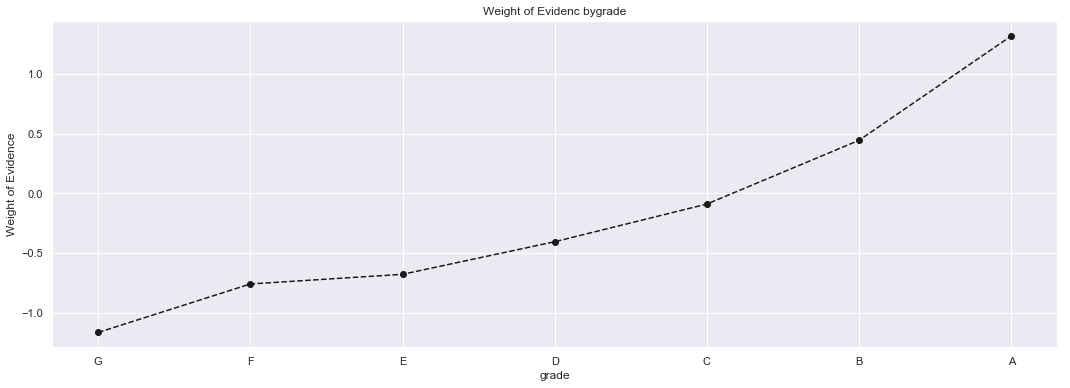

In [70]:
plot_woe(df_temp)

In [71]:
df_temp=woe_discrete(df_inputs,'home_ownership',df_target)
df_temp

C:\Users\senwangw\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\algorithms.py:1819: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


,home_ownership,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,OTHER,137,0.941606,0.000367,129.0,8.0,0.000352,0.001181,-1.210165,NaN,NaN,inf
1,RENT,150599,0.979475,0.403720,147508.0,3091.0,0.402746,0.456438,-0.125148,0.037869,1.085017,inf
2,OWN,33295,0.981349,0.089256,32674.0,621.0,0.089211,0.091701,-0.027532,0.001873,0.097616,inf
3,MORTGAGE,188956,0.983848,0.506546,185904.0,3052.0,0.507579,0.450679,0.118897,0.002500,0.146429,inf
4,ANY,1,1.000000,0.000003,1.0,0.0,0.000003,0.000000,inf,0.016152,inf,inf
5,NONE,40,1.000000,0.000107,40.0,0.0,0.000109,0.000000,inf,0.000000,NaN,inf


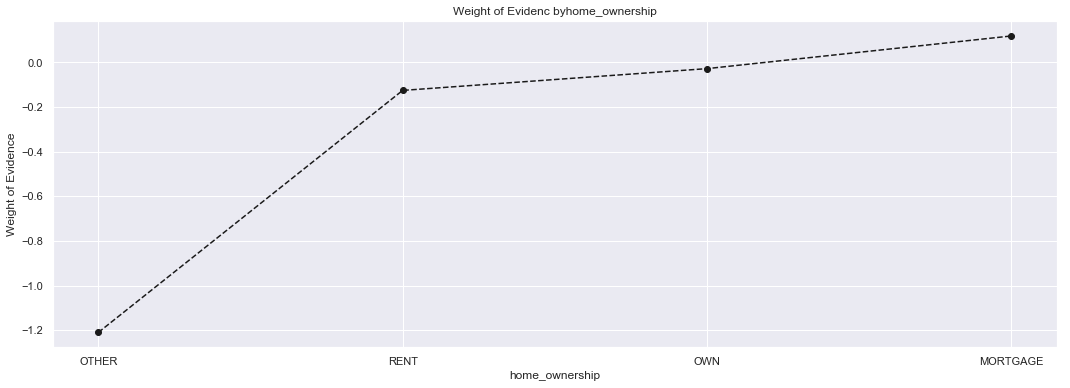

In [72]:
plot_woe(df_temp)

In [73]:
df_inputs['home_ownership1'] = sum([df_inputs['home_ownership:RENT'], df_inputs['home_ownership:OTHER'],
                                                      df_inputs['home_ownership:NONE'],df_inputs['home_ownership:ANY']])

In [74]:
df_inputs['addr_state'].unique()

array(['SC', 'NJ', 'GA', 'MA', 'CA', 'IL', 'NC', 'NY', 'TX', 'CT', 'FL',
       'VA', 'UT', 'AZ', 'MD', 'WI', 'MI', 'CO', 'TN', 'IN', 'AL', 'NV',
       'MT', 'RI', 'OR', 'MN', 'KS', 'AK', 'PA', 'OH', 'WA', 'KY', 'OK',
       'MO', 'NM', 'HI', 'WV', 'LA', 'VT', 'AR', 'DC', 'SD', 'NH', 'WY',
       'MS', 'DE', 'IA', 'NE', 'ID', 'ME'], dtype=object)

In [75]:
df_temp=woe_discrete(df_inputs,'addr_state',df_target)
df_temp

C:\Users\senwangw\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\algorithms.py:1819: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


,addr_state,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,NE,13,0.769231,0.000035,10.0,3.0,0.000027,0.000443,-2.786563,NaN,NaN,inf
1,IA,13,0.846154,0.000035,11.0,2.0,0.000030,0.000295,-2.285788,0.076923,0.500775,inf
2,MS,980,0.970408,0.002627,951.0,29.0,0.002597,0.004282,-0.500318,0.124254,1.785470,inf
3,MT,1103,0.970988,0.002957,1071.0,32.0,0.002924,0.004725,-0.479924,0.000580,0.020394,inf
4,TN,4845,0.975645,0.012988,4727.0,118.0,0.012906,0.017425,-0.300175,0.004657,0.179749,inf
5,RI,1647,0.977535,0.004415,1610.0,37.0,0.004396,0.005464,-0.217465,0.001890,0.082710,inf
6,NV,5221,0.977590,0.013996,5104.0,117.0,0.013936,0.017277,-0.214930,0.000056,0.002534,inf
7,LA,4359,0.978435,0.011685,4265.0,94.0,0.011645,0.013881,-0.175633,0.000845,0.039297,inf
8,HI,2001,0.978511,0.005364,1958.0,43.0,0.005346,0.006350,-0.172057,0.000075,0.003576,inf
9,SD,801,0.978777,0.002147,784.0,17.0,0.002141,0.002510,-0.159340,0.000266,0.012717,inf


In [77]:
if['addr_state:ND'] in df_inputs.columns.values:
    pass
else:
    df_inputs['addr_state:ND']=0

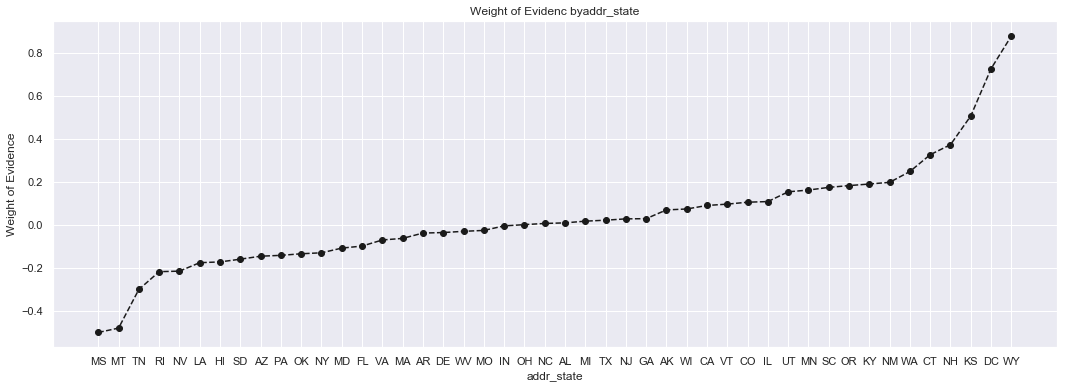

In [78]:
plot_woe(df_temp.iloc[2:  -2, :])

In [80]:
 #We create the following categories:
# 'ND' 'NE' 'IA' NV' 'FL' 'HI' 'AL'
# 'NM' 'VA'
# 'NY'
# 'OK' 'TN' 'MO' 'LA' 'MD' 'NC'
# 'CA'
# 'UT' 'KY' 'AZ' 'NJ'
# 'AR' 'MI' 'PA' 'OH' 'MN'
# 'RI' 'MA' 'DE' 'SD' 'IN'
# 'GA' 'WA' 'OR'
# 'WI' 'MT'
# 'TX'
# 'IL' 'CT'
# 'KS' 'SC' 'CO' 'VT' 'AK' 'MS'
# 'WV' 'NH' 'WY' 'DC' 'ME' 'ID'

# 'IA_NV_HI_ID_AL_FL' will be the reference category.

df_inputs['addr_state:ND_NE_IA_NV_FL_HI_AL'] = sum([df_inputs['addr_state:ND'], df_inputs['addr_state:NE'],
                                              df_inputs['addr_state:IA'], df_inputs['addr_state:NV'],
                                              df_inputs['addr_state:FL'], df_inputs['addr_state:HI'],
                                                          df_inputs['addr_state:AL']])

df_inputs['addr_state:NM_VA'] = sum([df_inputs['addr_state:NM'], df_inputs['addr_state:VA']])

df_inputs['addr_state:OK_TN_MO_LA_MD_NC'] = sum([df_inputs['addr_state:OK'], df_inputs['addr_state:TN'],
                                              df_inputs['addr_state:MO'], df_inputs['addr_state:LA'],
                                              df_inputs['addr_state:MD'], df_inputs['addr_state:NC']])

df_inputs['addr_state:UT_KY_AZ_NJ'] = sum([df_inputs['addr_state:UT'], df_inputs['addr_state:KY'],
                                              df_inputs['addr_state:AZ'], df_inputs['addr_state:NJ']])

df_inputs['addr_state:AR_MI_PA_OH_MN'] = sum([df_inputs['addr_state:AR'], df_inputs['addr_state:MI'],
                                              df_inputs['addr_state:PA'], df_inputs['addr_state:OH'],
                                              df_inputs['addr_state:MN']])

df_inputs['addr_state:RI_MA_DE_SD_IN'] = sum([df_inputs['addr_state:RI'], df_inputs['addr_state:MA'],
                                              df_inputs['addr_state:DE'], df_inputs['addr_state:SD'],
                                              df_inputs['addr_state:IN']])

df_inputs['addr_state:GA_WA_OR'] = sum([df_inputs['addr_state:GA'], df_inputs['addr_state:WA'],
                                              df_inputs['addr_state:OR']])

df_inputs['addr_state:WI_MT'] = sum([df_inputs['addr_state:WI'], df_inputs['addr_state:MT']])

df_inputs['addr_state:IL_CT'] = sum([df_inputs['addr_state:IL'], df_inputs['addr_state:CT']])

df_inputs['addr_state:KS_SC_CO_VT_AK_MS'] = sum([df_inputs['addr_state:KS'], df_inputs['addr_state:SC'],
                                              df_inputs['addr_state:CO'], df_inputs['addr_state:VT'],
                                              df_inputs['addr_state:AK'], df_inputs['addr_state:MS']])

df_inputs['addr_state:WV_NH_WY_DC_ME_ID'] = sum([df_inputs['addr_state:WV'], df_inputs['addr_state:NH'],
                                              df_inputs['addr_state:WY'], df_inputs['addr_state:DC'],
                                              df_inputs['addr_state:ME'], df_inputs['addr_state:ID']])

In [81]:
#process continuous variable
def woe_continuous(df, dis_var,tar_var):
    df=pd.concat([df[dis_var],tar_var],axis=1)
    df=pd.concat([df.groupby(df.columns.values[0],as_index=False)[df.columns.values[1]].count(),
               df.groupby(df.columns.values[0],as_index=False)[df.columns.values[1]].mean()],axis=1)
    df=df.iloc[: , [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    #df = df.sort_values(['WoE'])
    #df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df

In [83]:
df_temp=woe_continuous(df_inputs,'term_int',df_target)
df_temp

,term_int,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,36,270419,0.984136,0.724929,266129.0,4290.0,0.72662,0.633491,0.137158,NaN,NaN,0.040075
1,60,102609,0.975811,0.275071,100127.0,2482.0,0.27338,0.366509,-0.293161,0.008325,0.43032,0.040075


In [84]:
df_inputs['term:36']=np.where((df_inputs['term_int']==36),1,0)
df_inputs['term:60']=np.where((df_inputs['term_int']==60),1,0)

In [85]:
df_inputs['emp_length:0'] = np.where(df_inputs['emp_length_int'].isin([0]), 1, 0)
df_inputs['emp_length:1'] = np.where(df_inputs['emp_length_int'].isin([1]), 1, 0)
df_inputs['emp_length:2-4'] = np.where(df_inputs['emp_length_int'].isin(range(2, 5)), 1, 0)
df_inputs['emp_length:5-6'] = np.where(df_inputs['emp_length_int'].isin(range(5, 7)), 1, 0)
df_inputs['emp_length:7-9'] = np.where(df_inputs['emp_length_int'].isin(range(7, 10)), 1, 0)
df_inputs['emp_length:10'] = np.where(df_inputs['emp_length_int'].isin([10]), 1, 0)

In [86]:
df_inputs['purpose:educ__sm_b__wedd__ren_en__mov__house'] = sum([df_inputs['purpose:educational'], df_inputs['purpose:small_business'],
                                                                 df_inputs['purpose:wedding'], df_inputs['purpose:renewable_energy'],
                                                                 df_inputs['purpose:moving'], df_inputs['purpose:house']])
df_inputs['purpose:oth__med__vacation'] = sum([df_inputs['purpose:other'], df_inputs['purpose:medical'],
                                             df_inputs['purpose:vacation']])
df_inputs['purpose:major_purch__car__home_impr'] = sum([df_inputs['purpose:major_purchase'], df_inputs['purpose:car'],
                                                        df_inputs['purpose:home_improvement']])

In [87]:
df_inputs['mths_since_issue_d_factor'] = pd.cut(df_inputs['mths_since_issue_d'], 50)
df_inputs['mths_since_issue_d_factor']

427211      (43.2, 45.0]
206088      (63.0, 64.8]
136020      (52.2, 54.0]
412305      (43.2, 45.0]
36159     (100.8, 102.6]
260400     (35.91, 37.8]
29626       (90.0, 91.8]
117003      (52.2, 54.0]
378696      (41.4, 43.2]
159555      (55.8, 57.6]
258931     (35.91, 37.8]
435023      (43.2, 45.0]
434939      (43.2, 45.0]
166714      (57.6, 59.4]
397514      (41.4, 43.2]
412695      (43.2, 45.0]
326791      (39.6, 41.4]
399112      (41.4, 43.2]
386208      (41.4, 43.2]
90207       (50.4, 52.2]
177298      (57.6, 59.4]
41491     (111.6, 113.4]
84297       (48.6, 50.4]
193825      (61.2, 63.0]
391693      (41.4, 43.2]
431675      (43.2, 45.0]
66434       (48.6, 50.4]
454638      (46.8, 48.6]
89746       (50.4, 52.2]
50163       (46.8, 48.6]
367344      (41.4, 43.2]
349219      (39.6, 41.4]
346074      (39.6, 41.4]
290389      (37.8, 39.6]
214844      (64.8, 66.6]
222888      (68.4, 70.2]
122435      (52.2, 54.0]
465903      (46.8, 48.6]
390024      (41.4, 43.2]
377139      (41.4, 43.2]


In [88]:
# We create the following categories:
# < 38, 38 - 39, 40 - 41, 42 - 48, 49 - 52, 53 - 64, 65 - 84, > 84.
df_inputs['mths_since_issue_d:<38'] = np.where(df_inputs['mths_since_issue_d'].isin(range(38)), 1, 0)
df_inputs['mths_since_issue_d:38-39'] = np.where(df_inputs['mths_since_issue_d'].isin(range(38, 40)), 1, 0)
df_inputs['mths_since_issue_d:40-41'] = np.where(df_inputs['mths_since_issue_d'].isin(range(40, 42)), 1, 0)
df_inputs['mths_since_issue_d:42-48'] = np.where(df_inputs['mths_since_issue_d'].isin(range(42, 49)), 1, 0)
df_inputs['mths_since_issue_d:49-52'] = np.where(df_inputs['mths_since_issue_d'].isin(range(49, 53)), 1, 0)
df_inputs['mths_since_issue_d:53-64'] = np.where(df_inputs['mths_since_issue_d'].isin(range(53, 65)), 1, 0)
df_inputs['mths_since_issue_d:65-84'] = np.where(df_inputs['mths_since_issue_d'].isin(range(65, 85)), 1, 0)
df_inputs['mths_since_issue_d:>84'] = np.where(df_inputs['mths_since_issue_d'].isin(range(85, int(df_inputs['mths_since_issue_d'].max()))), 1, 0)

In [89]:
df_inputs['int_rate:<9.548'] = np.where((df_inputs['int_rate'] <= 9.548), 1, 0)
df_inputs['int_rate:9.548-12.025'] = np.where((df_inputs['int_rate'] > 9.548) & (df_inputs['int_rate'] <= 12.025), 1, 0)
df_inputs['int_rate:12.025-15.74'] = np.where((df_inputs['int_rate'] > 12.025) & (df_inputs['int_rate'] <= 15.74), 1, 0)
df_inputs['int_rate:15.74-20.281'] = np.where((df_inputs['int_rate'] > 15.74) & (df_inputs['int_rate'] <= 20.281), 1, 0)
df_inputs['int_rate:>20.281'] = np.where((df_inputs['int_rate'] > 20.281), 1, 0)

In [91]:
df_inputs_temp=df_inputs.loc[df_inputs['annual_inc']<=140000,:]

In [93]:
df_inputs_temp['annual_inc_factor']=pd.cut(df_inputs_temp['annual_inc'],50)
df_temp=woe_continuous(df_inputs_temp,'annual_inc_factor',df_target[df_inputs_temp.index])
df_temp

C:\Users\senwangw\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,annual_inc_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(1757.896, 4658.08]",15,0.866667,0.000043,13.0,2.0,0.000038,0.000311,-2.110493,NaN,NaN,0.031423
1,"(4658.08, 7420.16]",40,0.875000,0.000114,35.0,5.0,0.000102,0.000778,-2.036385,0.008333,0.074108,0.031423
2,"(7420.16, 10182.24]",287,0.982578,0.000818,282.0,5.0,0.000818,0.000778,0.050174,0.107578,2.086559,0.031423
3,"(10182.24, 12944.32]",547,0.978062,0.001558,535.0,12.0,0.001552,0.001868,-0.184935,0.004516,0.235109,0.031423
4,"(12944.32, 15706.4]",1210,0.975207,0.003447,1180.0,30.0,0.003424,0.004669,-0.310223,0.002856,0.125288,0.031423
5,"(15706.4, 18468.48]",1522,0.971748,0.004335,1479.0,43.0,0.004291,0.006693,-0.444374,0.003459,0.134151,0.031423
6,"(18468.48, 21230.56]",2928,0.978825,0.008340,2866.0,62.0,0.008316,0.009650,-0.148757,0.007077,0.295617,0.031423
7,"(21230.56, 23992.64]",2495,0.975150,0.007107,2433.0,62.0,0.007060,0.009650,-0.312549,0.003675,0.163792,0.031423
8,"(23992.64, 26754.72]",7016,0.975057,0.019985,6841.0,175.0,0.019850,0.027237,-0.316392,0.000093,0.003843,0.031423
9,"(26754.72, 29516.8]",5643,0.973064,0.016074,5491.0,152.0,0.015933,0.023658,-0.395310,0.001993,0.078918,0.031423


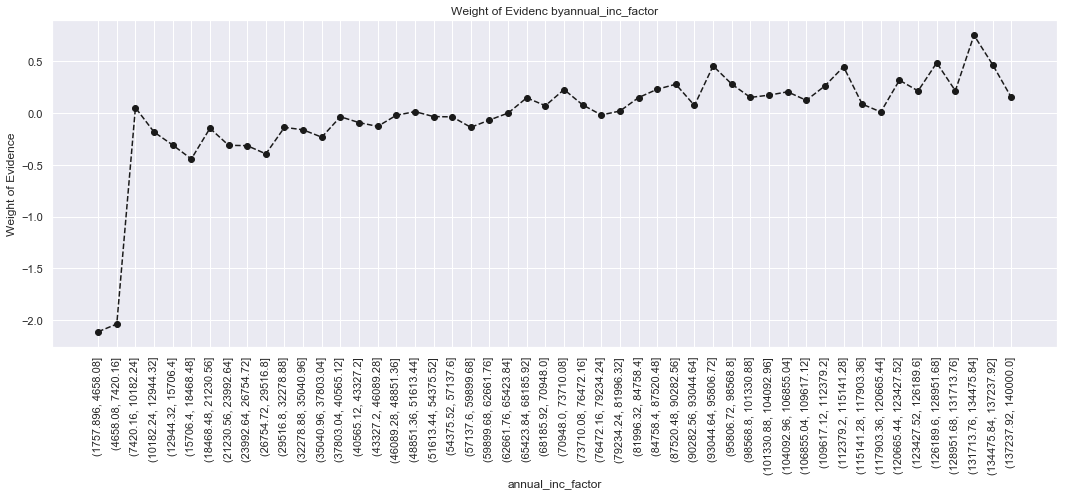

In [94]:
plot_woe(df_temp,90)

In [95]:
df_inputs['annual_inc:<20K'] = np.where((df_inputs['annual_inc'] <= 20000), 1, 0)
df_inputs['annual_inc:20K-30K'] = np.where((df_inputs['annual_inc'] > 20000) & (df_inputs['annual_inc'] <= 30000), 1, 0)
df_inputs['annual_inc:30K-40K'] = np.where((df_inputs['annual_inc'] > 30000) & (df_inputs['annual_inc'] <= 40000), 1, 0)
df_inputs['annual_inc:40K-50K'] = np.where((df_inputs['annual_inc'] > 40000) & (df_inputs['annual_inc'] <= 50000), 1, 0)
df_inputs['annual_inc:50K-60K'] = np.where((df_inputs['annual_inc'] > 50000) & (df_inputs['annual_inc'] <= 60000), 1, 0)
df_inputs['annual_inc:60K-70K'] = np.where((df_inputs['annual_inc'] > 60000) & (df_inputs['annual_inc'] <= 70000), 1, 0)
df_inputs['annual_inc:70K-80K'] = np.where((df_inputs['annual_inc'] > 70000) & (df_inputs['annual_inc'] <= 80000), 1, 0)
df_inputs['annual_inc:80K-90K'] = np.where((df_inputs['annual_inc'] > 80000) & (df_inputs['annual_inc'] <= 90000), 1, 0)
df_inputs['annual_inc:90K-100K'] = np.where((df_inputs['annual_inc'] > 90000) & (df_inputs['annual_inc'] <= 100000), 1, 0)
df_inputs['annual_inc:100K-120K'] = np.where((df_inputs['annual_inc'] > 100000) & (df_inputs['annual_inc'] <= 120000), 1, 0)
df_inputs['annual_inc:120K-140K'] = np.where((df_inputs['annual_inc'] > 120000) & (df_inputs['annual_inc'] <= 140000), 1, 0)
df_inputs['annual_inc:>140K'] = np.where((df_inputs['annual_inc'] > 140000), 1, 0)

In [96]:
df_inputs['mths_since_last_delinq:Missing'] = np.where((df_inputs['mths_since_last_delinq'].isnull()), 1, 0)
df_inputs['mths_since_last_delinq:0-3'] = np.where((df_inputs['mths_since_last_delinq'] >= 0) & (df_inputs['mths_since_last_delinq'] <= 3), 1, 0)
df_inputs['mths_since_last_delinq:4-30'] = np.where((df_inputs['mths_since_last_delinq'] >= 4) & (df_inputs['mths_since_last_delinq'] <= 30), 1, 0)
df_inputs['mths_since_last_delinq:31-56'] = np.where((df_inputs['mths_since_last_delinq'] >= 31) & (df_inputs['mths_since_last_delinq'] <= 56), 1, 0)
df_inputs['mths_since_last_delinq:>=57'] = np.where((df_inputs['mths_since_last_delinq'] >= 57), 1, 0)